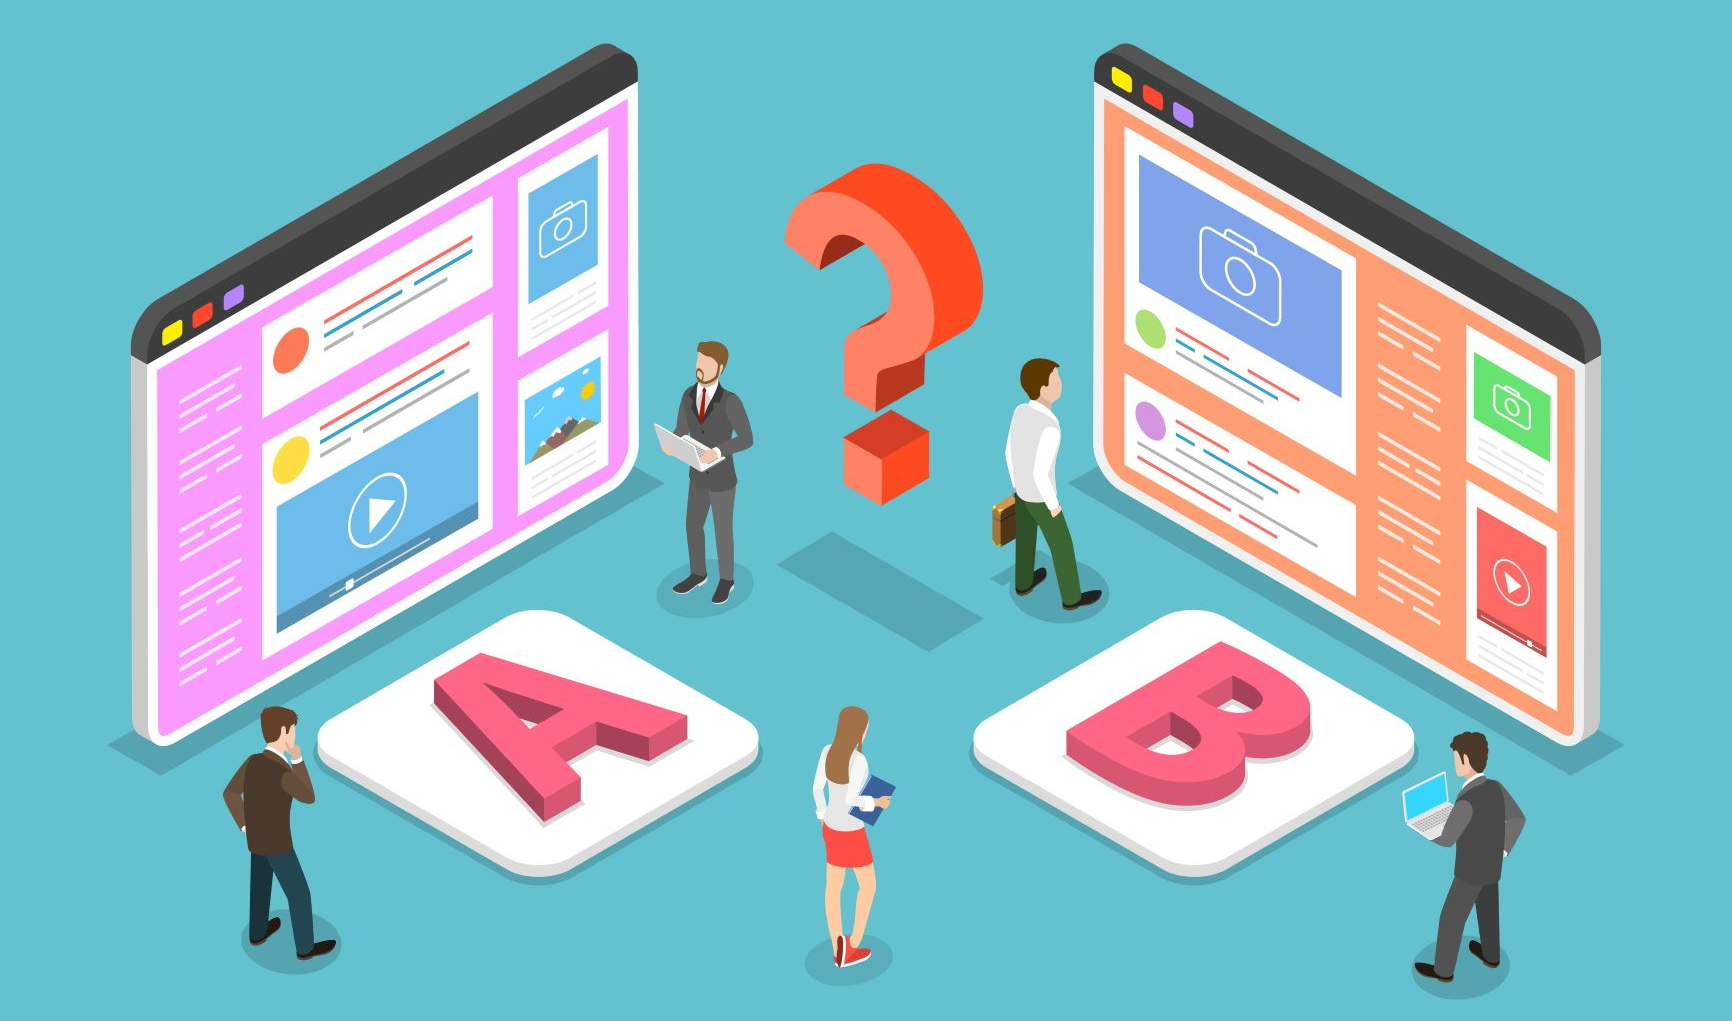

## Библиотеки 

In [80]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import scipy.stats

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(rc={'figure.figsize':(16,8)})
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('..')
from stattests.generation import generate_data
from stattests.tests import t_test
from stattests.utils import plot_cdf
from stattests.utils import frame_from_params, save_gif_and_show

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Теория

[Исходная статья](https://vkteam.medium.com/practitioners-guide-to-statistical-tests-ed2d580ef04f)

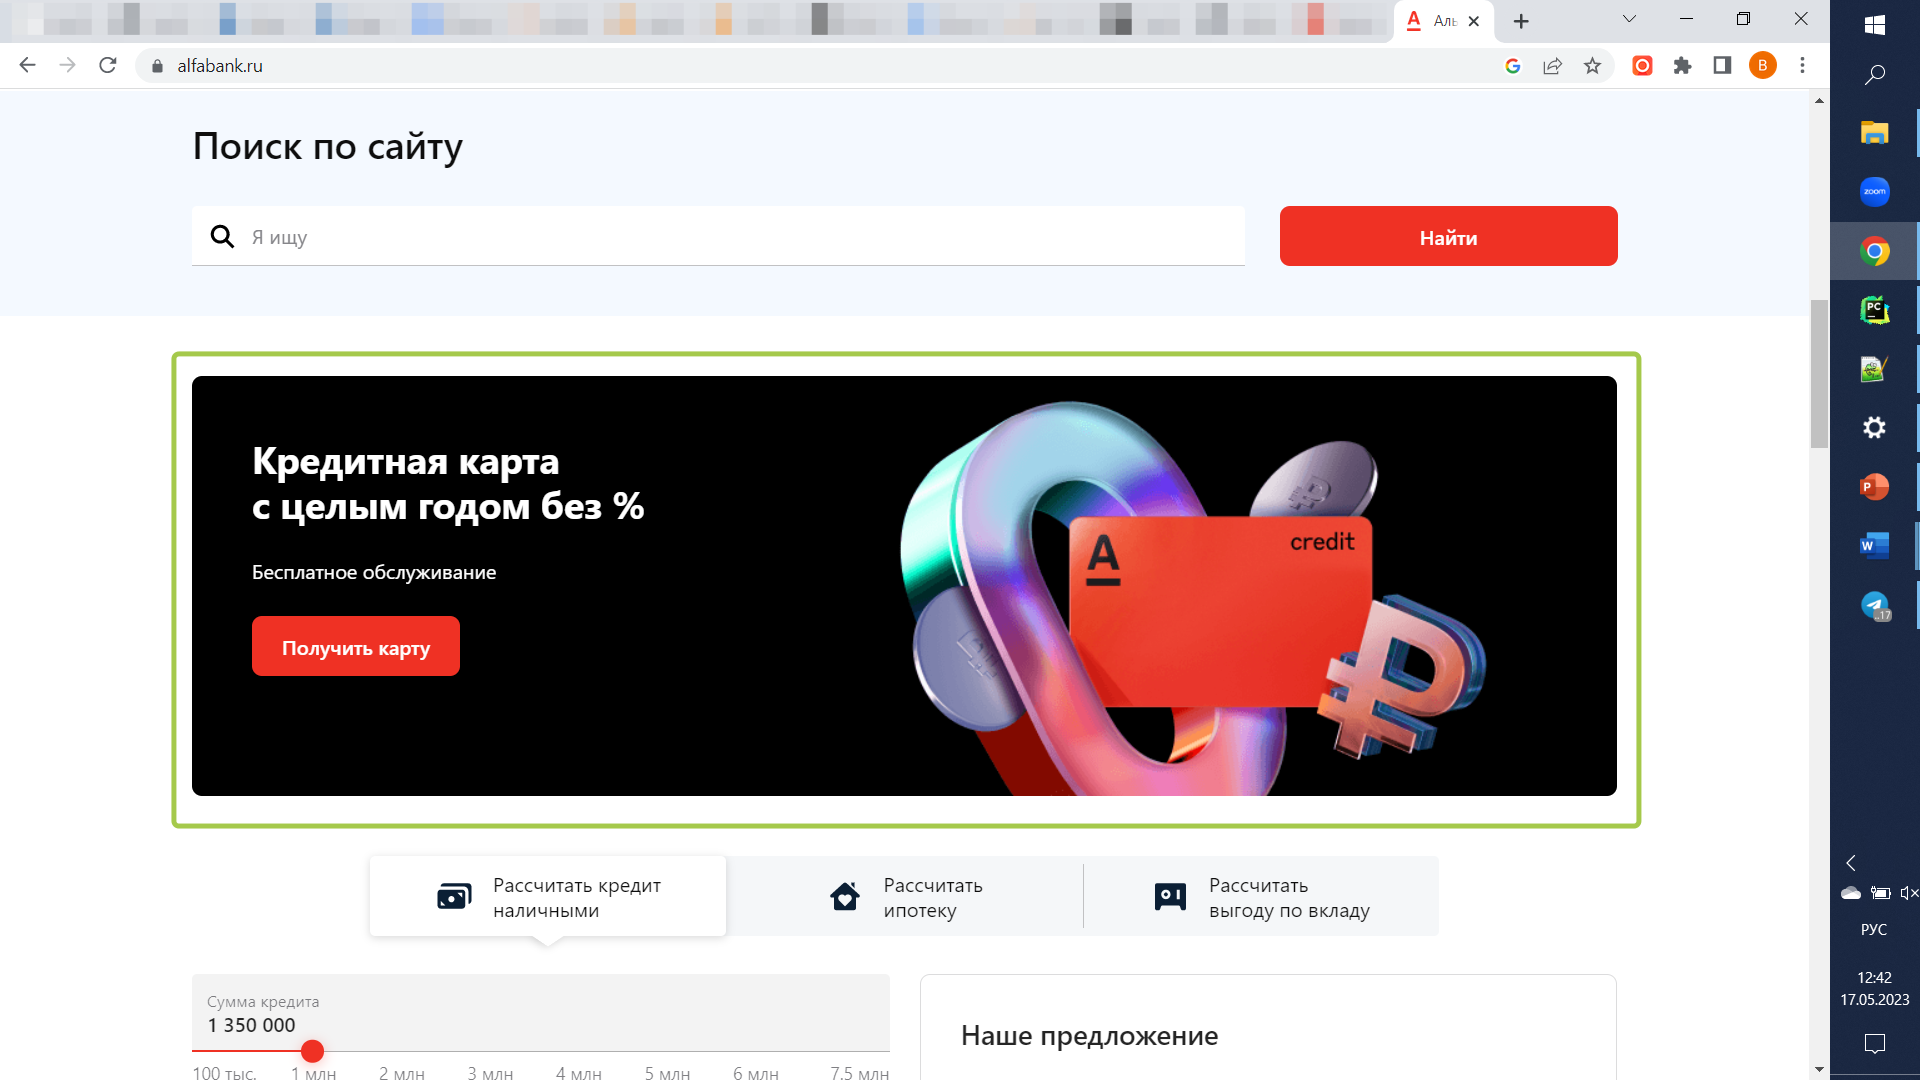

**Определение групп пользователей**:
- *Control group* - we will use our current production model
- *Treatment group* - we will deploy the new CTR prediction model

**Hypothesis Testing**
- The null hypothesis states that nothing has changed. In our example, it would be “the average number of clicks in the control and treatment groups are the same”.
- The alternative hypothesis says that there is a notable difference between groups.

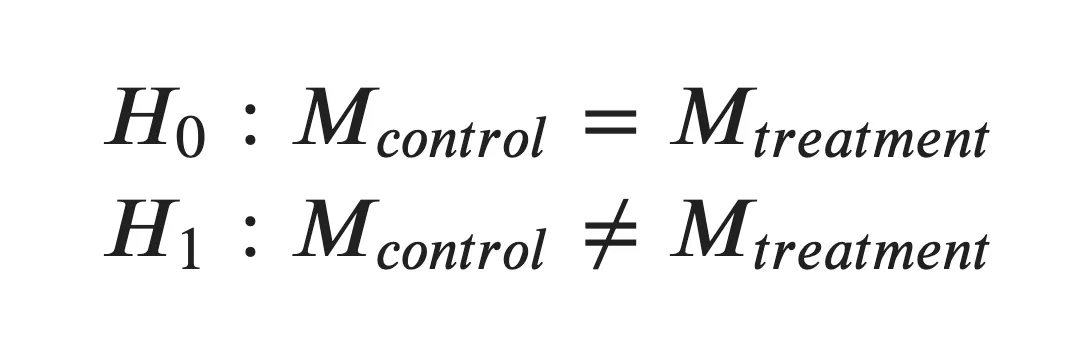

**False-positive rate (FPR)**  
FPR is the probability of rejecting H0 while it is actually true.  
If a statistical procedure is correct (all assumptions are met and the statistical test works fine with the given data), this rate is controlled by **p-value**.

**Sensitivity**  
Sensitivity is the probability of rejecting H0 while it is actually not true.

**Вопросы:**  
    - Как связаны FPR и ошибка первого рода? А Sensitivity и ошибка второго рода?  
    - Какие значения примет FPR и Sensitivity, если мы будем всегда принимать нулевую гипотезу? А если отвергать?

**Пример `

**FPR versus Sensitivity** 

The vertical grey line corresponds to 5% FPR, the standard p-value threshold. The intersection of this line with the curve gives you the sensitivity of your test that corresponds to 5% FPR. We will call it **the power of the statistical test** at 5% FPR (or just power). In this example, the power of the test at 5% FPR is 65%.

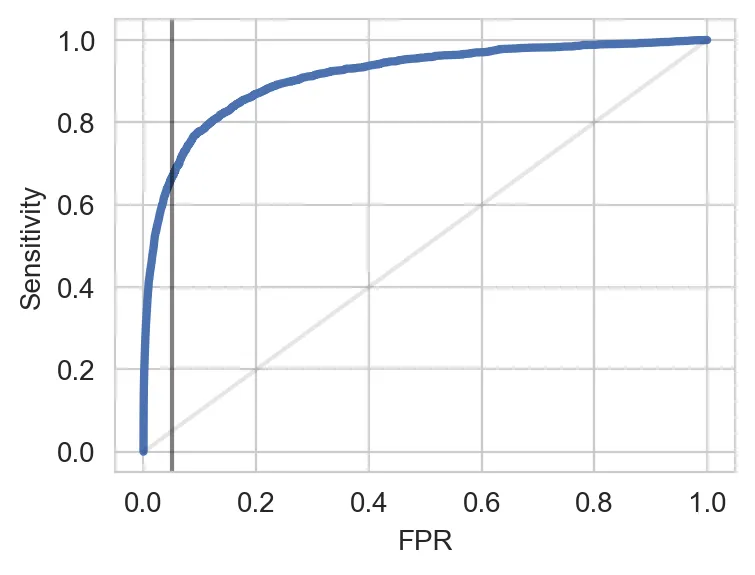

**The goal:**  
We will fix FPR to 5% and compare the powers of a vast variety of tests given this level.

**Power of the statistical test depends on four things:**

- The test itself
- Distribution of the experimental data
- Effect size
- Size of the test groups

## Data Generation 

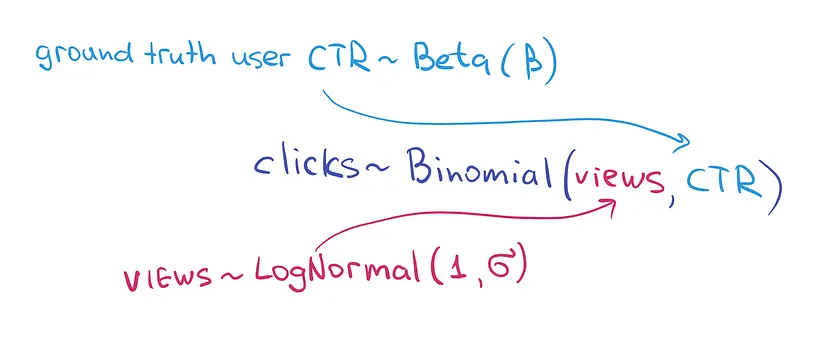

### Views 

In [110]:
figsize = (16, 8)
dpi = 200

- skew: skewness of views distribution
- N: number of users in each experimental group (in control and in treatment)

In [142]:
skew = 1
N = 5000

[Log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution)  
[scipy.stats.norm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.norm)

In [141]:
views = np.exp(scipy.stats.norm(1, skew).rvs(N)).astype(int) + 1

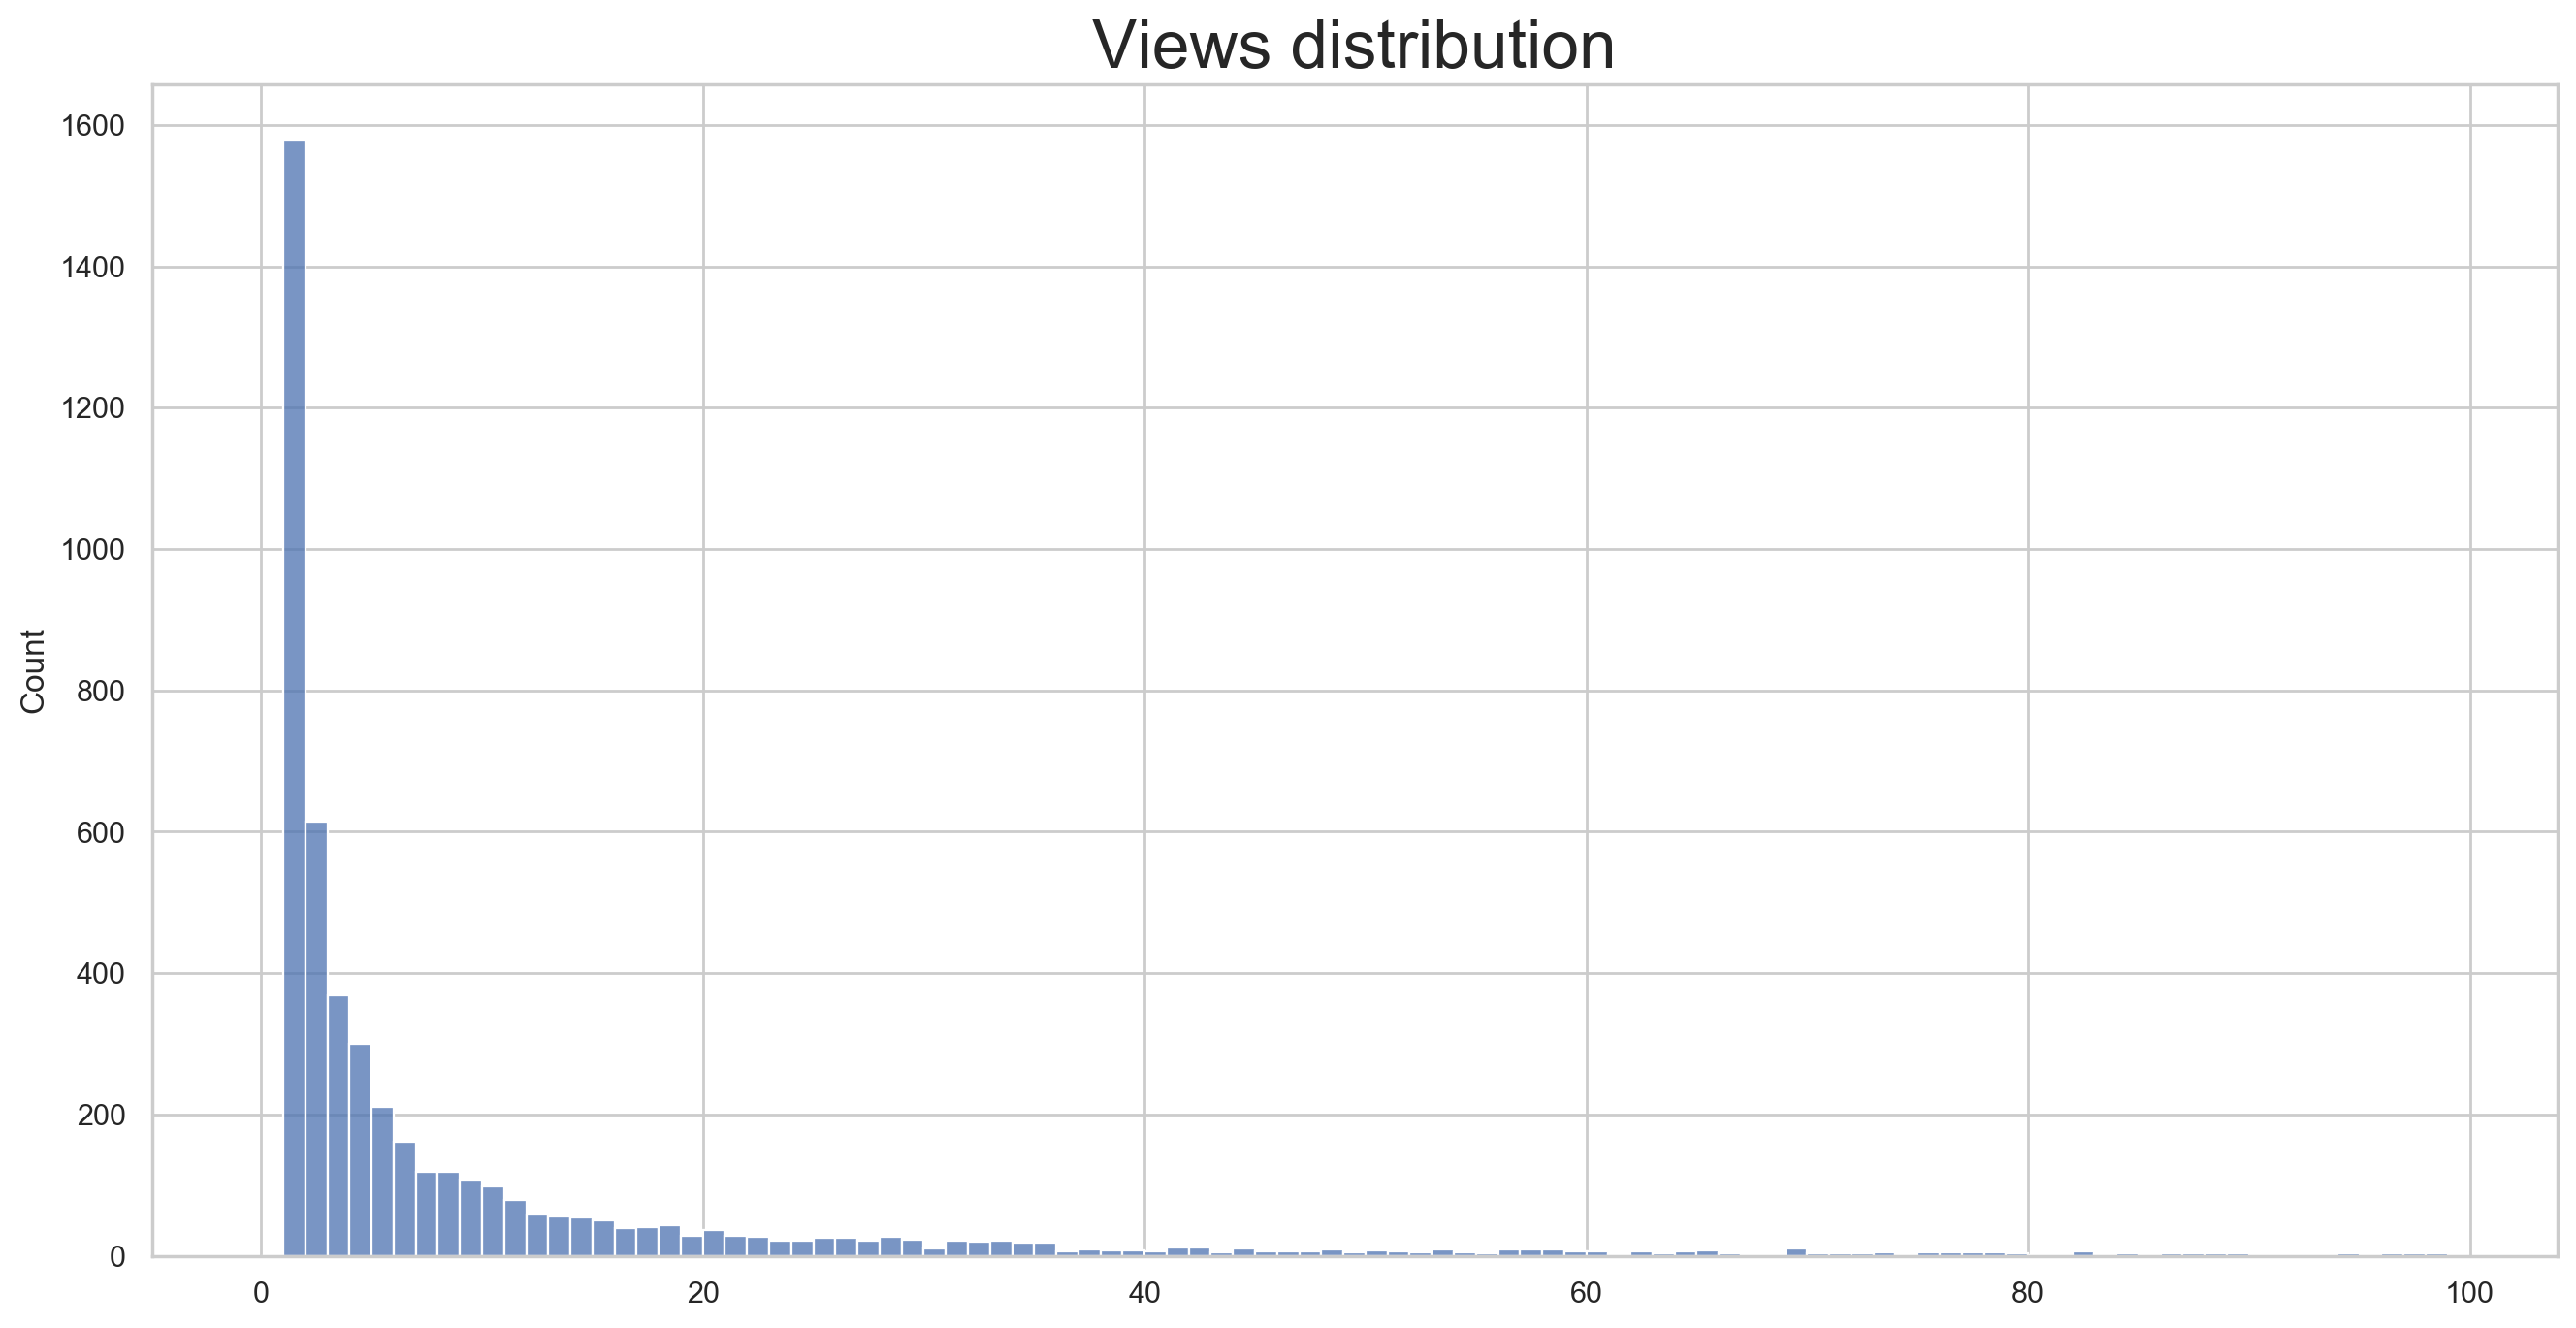

In [163]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
sns.histplot(views, stat='count', bins=range(0, 100), kde=False)
ax.set_title('Views distribution')
ax.title.set_size(25)

In [164]:
np.mean(views)

20.2132

Most of the users saw a small number of ads, and few users — a lot.

попробовать 1 - 3.

### Success rates (Ground Truth User CTR)

- mean_success_rate: mean success rate in control group
- beta: parameter of success rate distribution

In [114]:
mean_success_rate = 0.2
beta = 1000

[Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution)  
[scipy.stats.beta](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html)

In [115]:
alpha = mean_success_rate * beta / (1 - mean_success_rate) # показать формулу среднего
success_rates = scipy.stats.beta(alpha, beta).rvs(N)

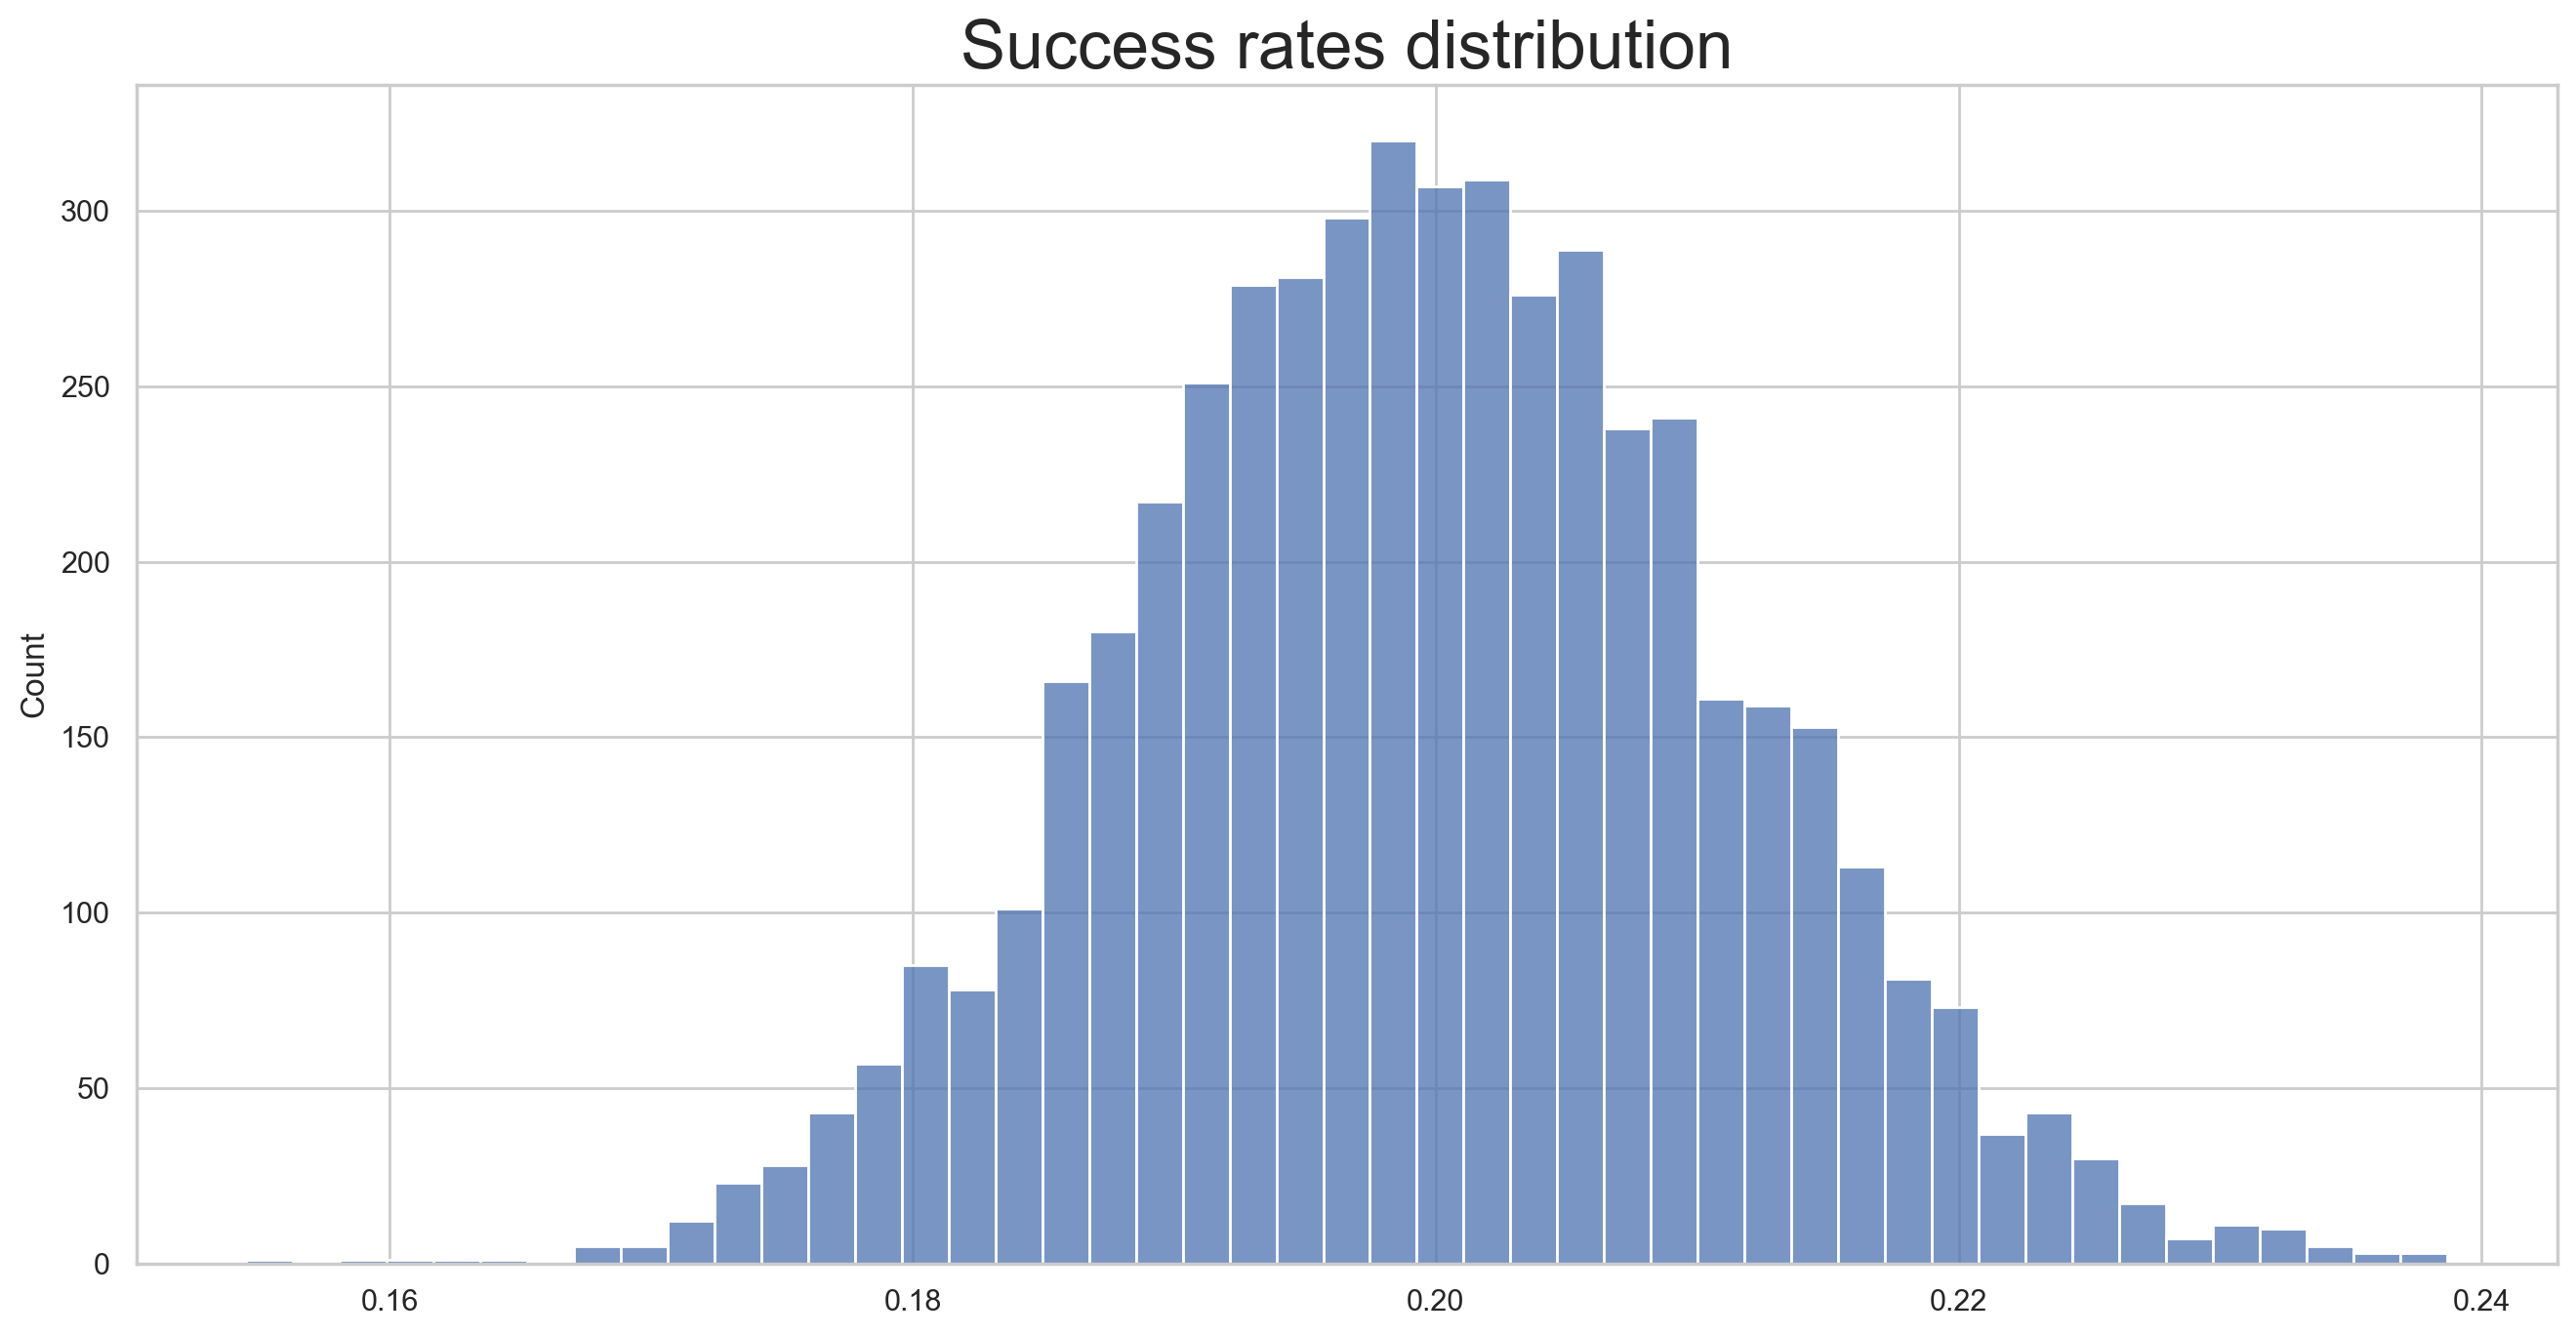

In [165]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
sns.histplot(success_rates, ax=ax, kde=False)
ax.set_title('Success rates distribution')
ax.title.set_size(25)

### Clicks

[Binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution)  
[scipy.stats.binom](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html)

In [117]:
clicks = scipy.stats.binom(n=views, p=success_rates).rvs()

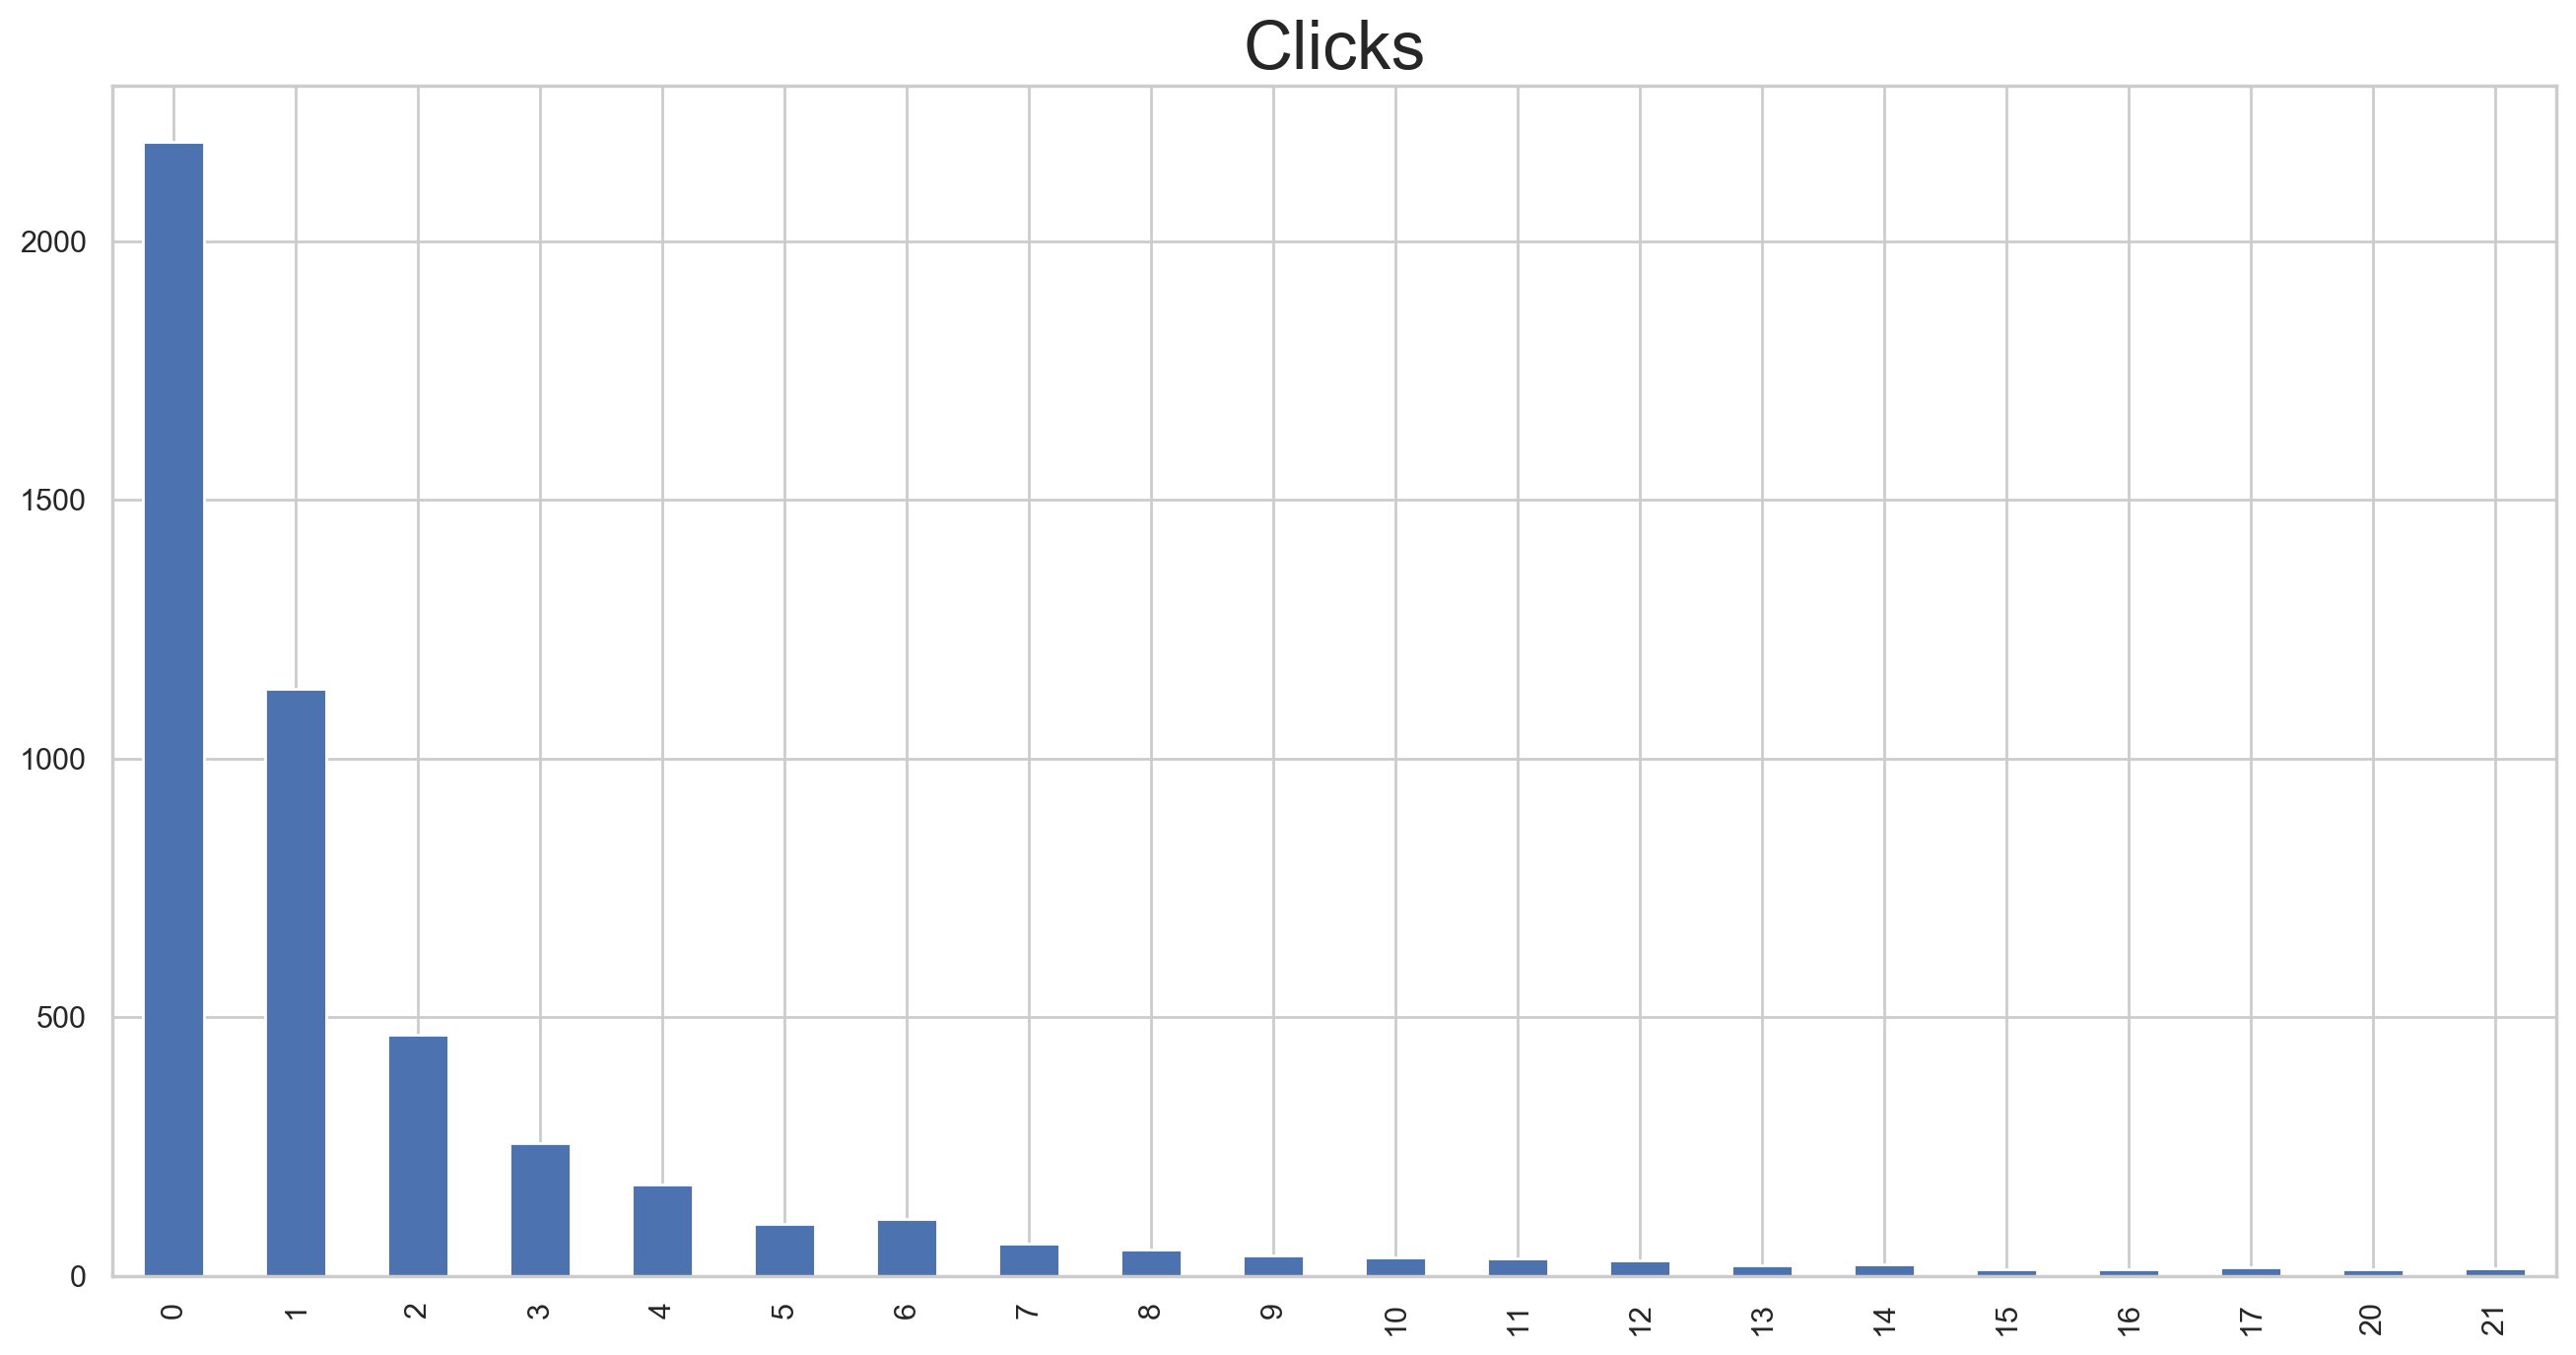

In [118]:
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
tmp_stats = pd.Series(clicks).value_counts().iloc[0:20].sort_index()
tmp_stats.plot(kind='bar')
ax.set_title('Clicks')
ax.title.set_size(25)

### Все вместе

In [119]:
df = pd.DataFrame(zip(views, success_rates, clicks), columns=['views', 'success_rates', 'clicks'])

In [120]:
df.head()

,views,success_rates,clicks
0,11,0.189830,2
1,8,0.204822,3
2,1,0.200507,0
3,42,0.224246,11
4,19,0.205214,1


In [121]:
df.shape

(5000, 3)

In [14]:
df.describe()

,views,success_rate,clicks
count,5000.000000,5000.000000,5000.000000
mean,20.494000,0.200000,4.129800
std,96.330796,0.011228,19.680244
min,1.000000,0.160835,0.000000
25%,1.000000,0.192439,0.000000
50%,3.000000,0.199838,1.000000
75%,11.000000,0.207346,2.000000
max,3182.000000,0.242804,671.000000


### Treatment group  

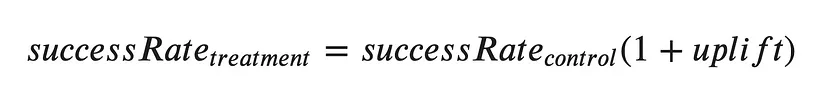

**Whole pipeline**
- Initialize N users for the control group, N for the treatment group.
- Generate the number of ad views for each user in treatment and control groups from the same log-normal distribution.
- Generate the ground truth user CTR for each user from beta-distribution with mean **success_rate_control** for the control group and **success_rate_control * (1 + uplift)** for the treatment group.
- Generate the number of ad clicks for each user from a binomial distribution with the number of trials equal to the number of views and the success rate equal to the ground truth user CTR.

Рассмотреть два случая:
- есть не нулевое улучшение
- изменений нет

In [143]:
ab_params = {'success_rate': 0.02,
             'uplift': 0.1,
             'beta': 1000,
             'skew': 2,
             'N': 10000,
             'NN': 1}
(views_0_ab, clicks_0_ab), (views_1_ab, clicks_1_ab), (success_rates_0_ab, success_rates_1_ab) = generate_data(**ab_params)

df_control = pd.DataFrame(zip(views_0_ab[0], success_rates_0_ab[0], clicks_0_ab), columns=['views', 'success_rates', 'clicks'])
df_treatment = pd.DataFrame(zip(views_1_ab[0], success_rates_1_ab[0], clicks_1_ab), columns=['views','success_rates', 'clicks'])

In [144]:
df_control.head()

,views,success_rates,clicks
0,1.0,0.019570,1.0
1,17.0,0.022576,2.0
2,33.0,0.016681,1.0
3,12.0,0.026807,0.0
4,1.0,0.021456,0.0


In [145]:
df_control.shape

(10000, 3)

In [146]:
ctr_control = df_control.clicks.mean()
ctr_control

0.3996

In [147]:
ctr_treatment = df_treatment.clicks.mean()
ctr_treatment

0.4362

In [148]:
ctr_treatment / ctr_control

1.0915915915915915

In [149]:
df_control.clicks.describe()

count    10000.000000
mean         0.399600
std          3.047466
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        245.000000
Name: clicks, dtype: float64

In [150]:
df_treatment.clicks.describe()

count    10000.000000
mean         0.436200
std          2.065903
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         79.000000
Name: clicks, dtype: float64

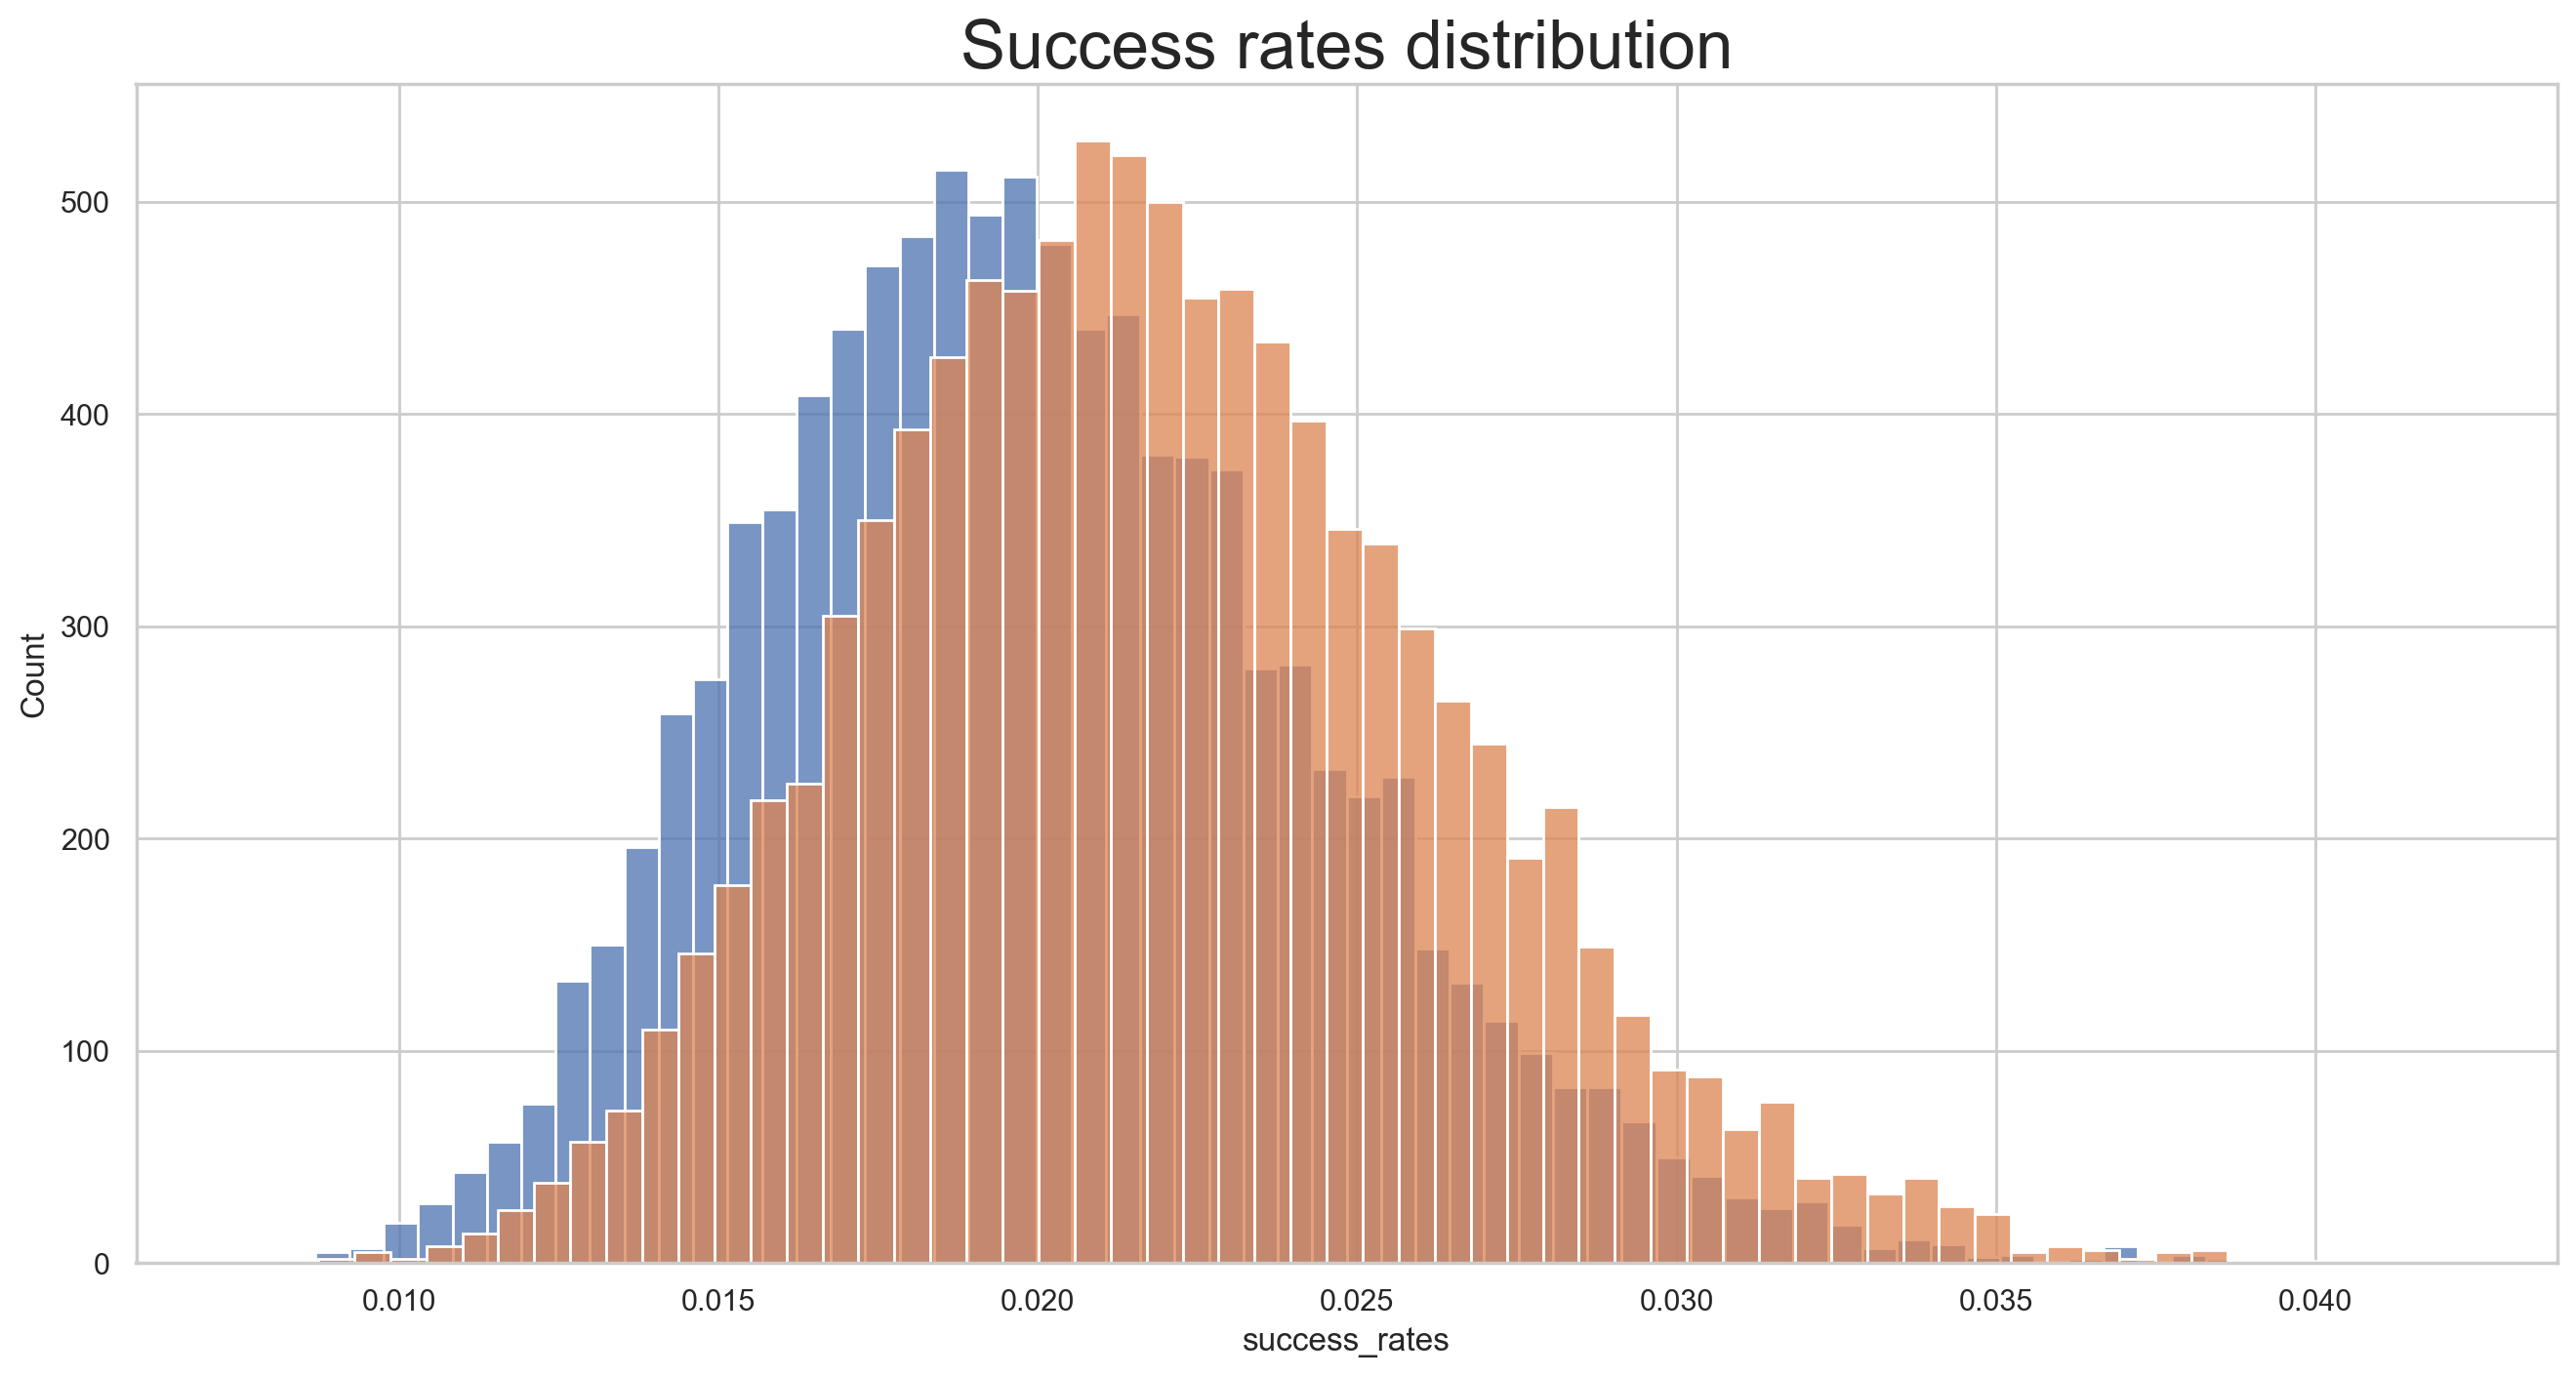

In [169]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

sns.histplot(df_control.success_rates, ax=ax)
sns.histplot(df_treatment.success_rates, ax=ax)

ax.set_title('Success rates distribution')
ax.title.set_size(25)

### Sensitivity and p-value CDF 

[Cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function)

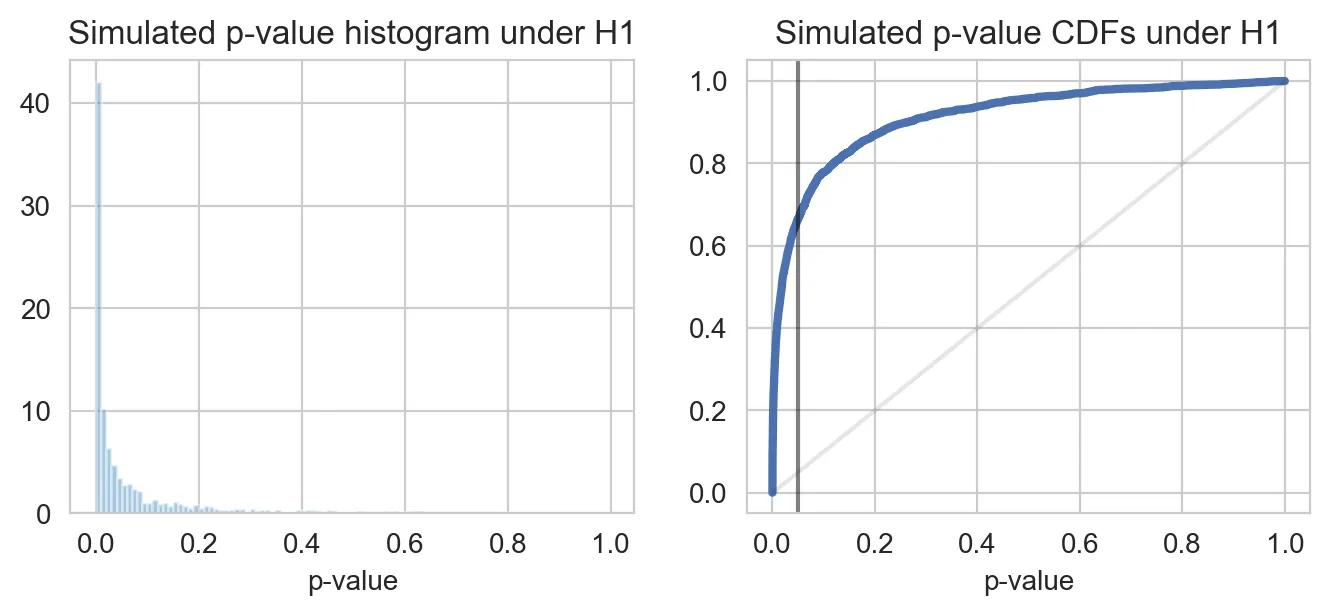

**Note how the p-value CDF here is actually equal to the statistical test sensitivity.** If we were to take the CDF’s value at 0.05 p-value, this would actually be the fraction of experiments when p-value <= 0.05. CDF(0.05) is the fraction of experiments when we reject H0. And as we know that H0 is not true in all experiments, CDF(0.05) is the fraction of experiments in which we reject H0 when H0 is actually not true (sensitivity). So the plot we see here is exactly the ROC curve for the statistical test (sensitivity vs FPR). We will use this approach to plot ROC curves for a wide variety of statistical tests and to compare them.

### P-value sanity check

- We always claim that False Positive Rate is controlled by a p-value threshold
- If p-value controls FPR reasonably well, the test will give us the correct results despite the violation of the assumptions.
- So for every statistical test, we should be able to check whether p-value controls FPR for our data.

A/A tests:
- Let’s use the same data generation pipeline, but with zero uplift.
- The p-value correctly controls FPR if and only if the p-value is distributed uniformly on [0, 1] for A/A tests.
-  We claim that in this case FPR is equal to our p-value threshold, e.g. for A/A tests, p-value falls below the 0.05 threshold in only 5% of cases. 

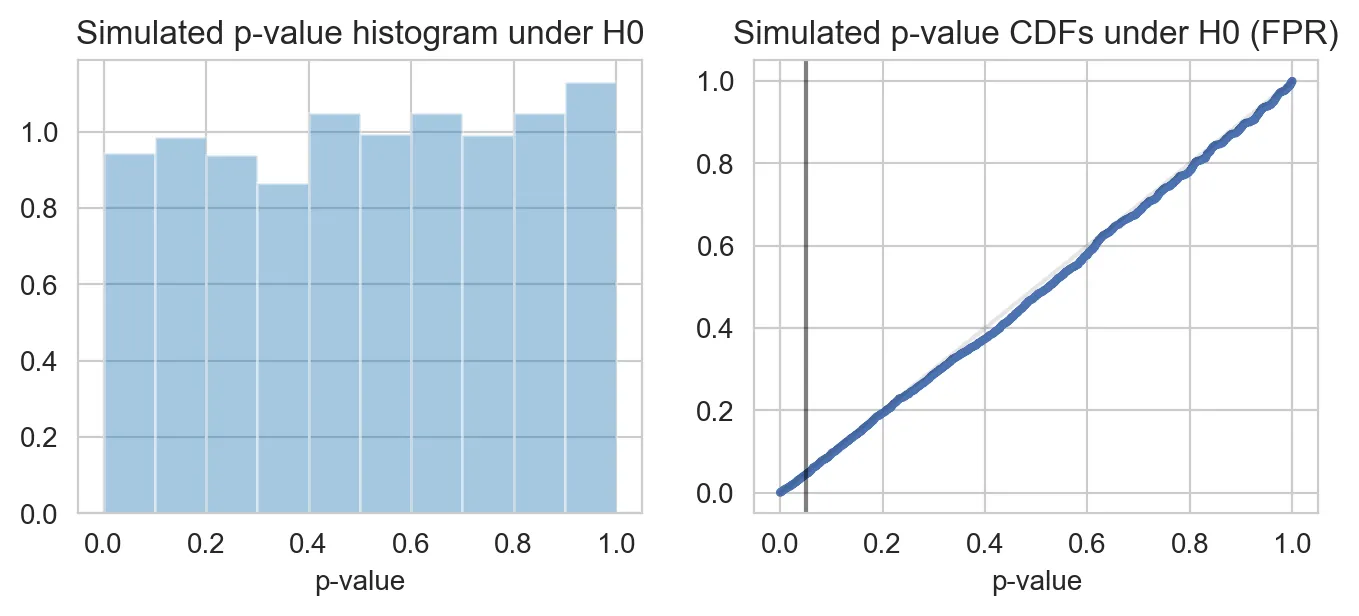

## Tests on the number of clicks

### Эксперименты

In [171]:
skew = 1.0 # skewness of views distribution
N = 5000 # number of users in each experimental group (in control and in treatment)
NN = 2000 # number of experiments
success_rate = 0.02 # mean success rate in control group
uplift = 0.2 # relative uplift of mean success rate in treatment group
beta = 1000 # parameter of success rate distribution

In [172]:
ab_params = {'success_rate': success_rate,
             'uplift': uplift,
             'beta': beta,
             'skew': skew,
             'N': N,
             'NN': NN}

aa_params = {'success_rate': success_rate,
             'uplift': 0,
             'beta': beta,
             'skew': skew,
             'N': N,
             'NN': NN}

In [173]:
(views_0_ab, clicks_0_ab), (views_1_ab, clicks_1_ab), (success_rates_0_ab, success_rates_1_ab) = generate_data(**ab_params)
(views_0_aa, clicks_0_aa), (views_1_aa, clicks_1_aa), (success_rates_0_aa, success_rates_1_aa) = generate_data(**aa_params)

In [174]:
views_0_ab.shape

(2000, 5000)

In [175]:
clicks_0_ab.shape

(2000, 5000)

### **Проверка А/B теста**

In [176]:
i = 555

*Control*

In [177]:
views_control = views_0_ab[i,:]
clicks_control = clicks_0_ab[i,:]

In [178]:
np.mean(clicks_control)

0.0934

*Treatment*

In [179]:
views_treatment = views_1_ab[i,:]
clicks_treatment = clicks_1_ab[i,:]

In [180]:
np.mean(clicks_treatment)

0.1198

*Control vs Treatment*

In [181]:
np.mean(clicks_treatment) / np.mean(clicks_control)

1.2826552462526768

In [183]:
pd.Series(map(np.mean, clicks_0_ab)).describe()

count    2000.000000
mean        0.099596
std         0.004748
min         0.086600
25%         0.096400
50%         0.099600
75%         0.103000
max         0.114400
dtype: float64

In [184]:
pd.Series(map(np.mean, clicks_1_ab)).describe()

count    2000.000000
mean        0.119527
std         0.005267
min         0.102600
25%         0.116000
50%         0.119400
75%         0.123200
max         0.136400
dtype: float64

Неожиданные результаты тестирования:

In [192]:
for i in range(NN):
    if np.mean(clicks_0_ab[i,:]) >= np.mean(clicks_1_ab[i,:]):
        print(i)

70
134
1517
1989


### **Проверка A/A теста**

In [193]:
pd.Series(map(np.mean, clicks_0_aa)).describe()

count    2000.000000
mean        0.099659
std         0.004697
min         0.084000
25%         0.096600
50%         0.099600
75%         0.102800
max         0.116600
dtype: float64

In [194]:
pd.Series(map(np.mean, clicks_1_aa)).describe()

count    2000.000000
mean        0.099443
std         0.004634
min         0.083000
25%         0.096200
50%         0.099400
75%         0.102400
max         0.113800
dtype: float64

In [195]:
pd.Series(map(np.mean, views_0_aa)).describe()

count    2000.000000
mean        4.982702
std         0.082966
min         4.693400
25%         4.925000
50%         4.984600
75%         5.038850
max         5.268400
dtype: float64

In [196]:
pd.Series(map(np.mean, views_1_aa)).describe()

count    2000.000000
mean        4.980720
std         0.085166
min         4.716400
25%         4.920150
50%         4.979900
75%         5.037650
max         5.270400
dtype: float64

###  [T-test on the number of clicks](https://en.wikipedia.org/wiki/Student%27s_t-test#Independent_two-sample_t-test)

#### Пример

T-tests involve strong assumptions on data, such as normality and equal variances among test groups. However, empirically, t-tests are robust to violations of the assumptions.

In [197]:
ab_data = t_test(clicks_0_ab, clicks_1_ab)
aa_data = t_test(clicks_0_aa, clicks_1_aa)

In [198]:
ab_data.shape

(2000,)

In [199]:
aa_data.shape

(2000,)

In [200]:
pd.Series(ab_data).describe()

count    2.000000e+03
mean     4.579219e-02
std      1.158097e-01
min      8.015023e-10
25%      5.213398e-04
50%      4.309609e-03
75%      3.277469e-02
max      1.000000e+00
dtype: float64

In [201]:
pd.Series(aa_data).describe()

count    2000.000000
mean        0.502071
std         0.284527
min         0.000455
25%         0.258957
50%         0.505575
75%         0.744941
max         1.000000
dtype: float64

Text(0, 0.5, 'Count of experiments')

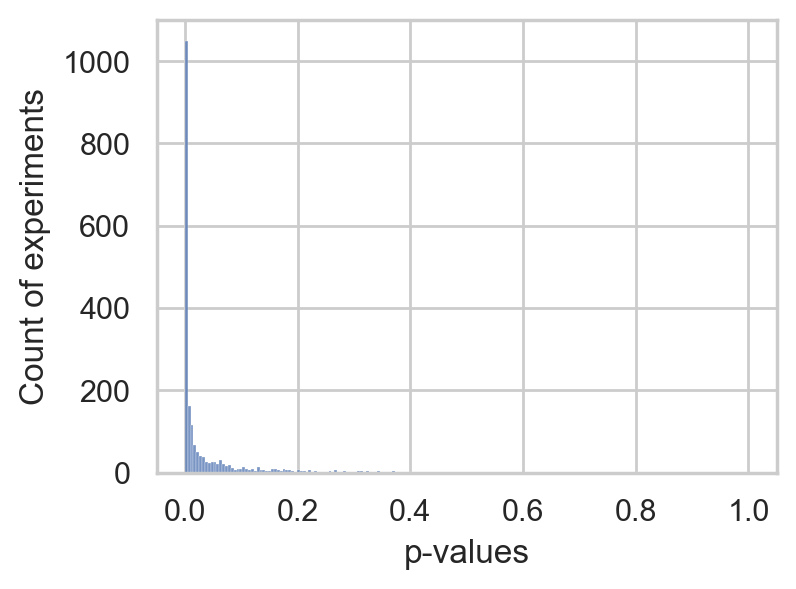

In [206]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
sns.histplot(ab_data)
ax.set_xlabel("p-values")
ax.set_ylabel("Count of experiments")

In [207]:
sum(ab_data < 0.05)

1590

In [208]:
sum(ab_data < 0.05) / ab_data.shape

array([0.795])

Text(0, 0.5, 'Sensitivity')

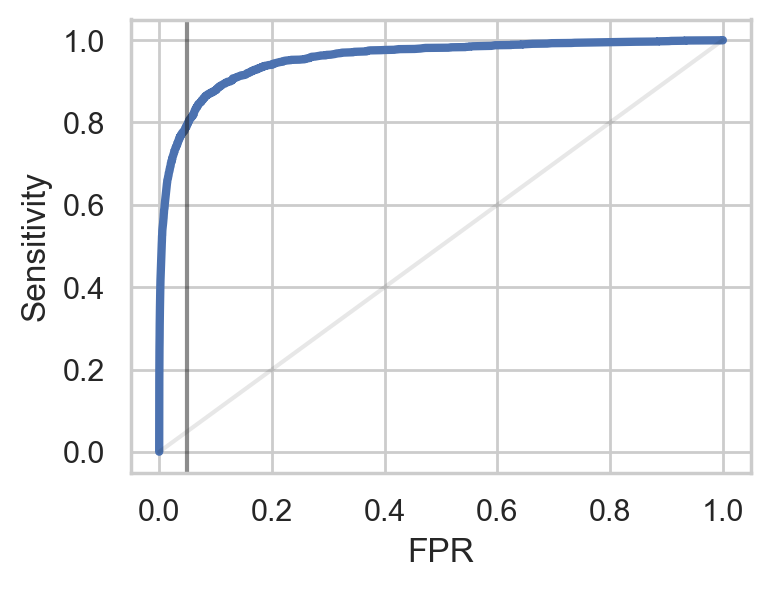

In [209]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
plot_cdf(ab_data, 'TTest', ax)
ax.plot(np.linspace(0, 1, 10000), np.linspace(0, 1, 10000), 'k', alpha=0.1)
ax.axvline(0.05, color='k', alpha=0.5)
ax.set_xlabel('FPR')
ax.set_ylabel('Sensitivity')

Text(0, 0.5, 'Count of experiments')

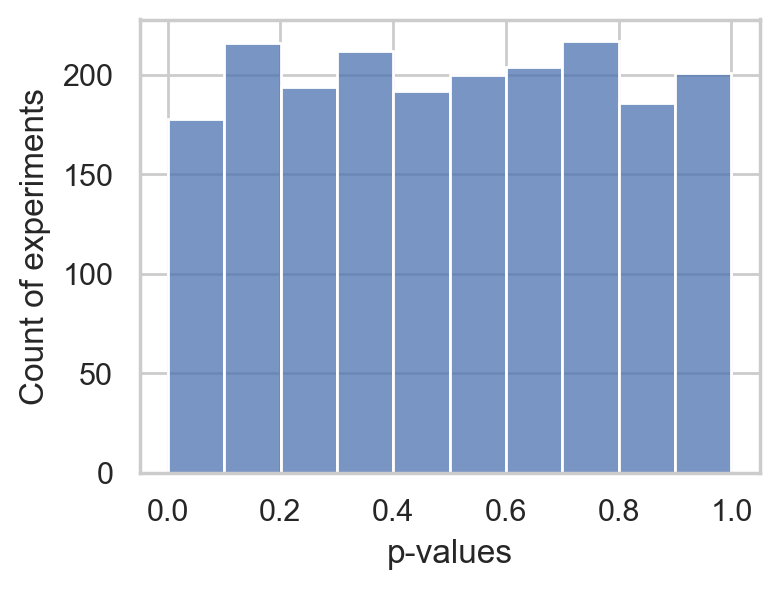

In [210]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
sns.histplot(aa_data, bins=10)
ax.set_xlabel("p-values")
ax.set_ylabel("Count of experiments")

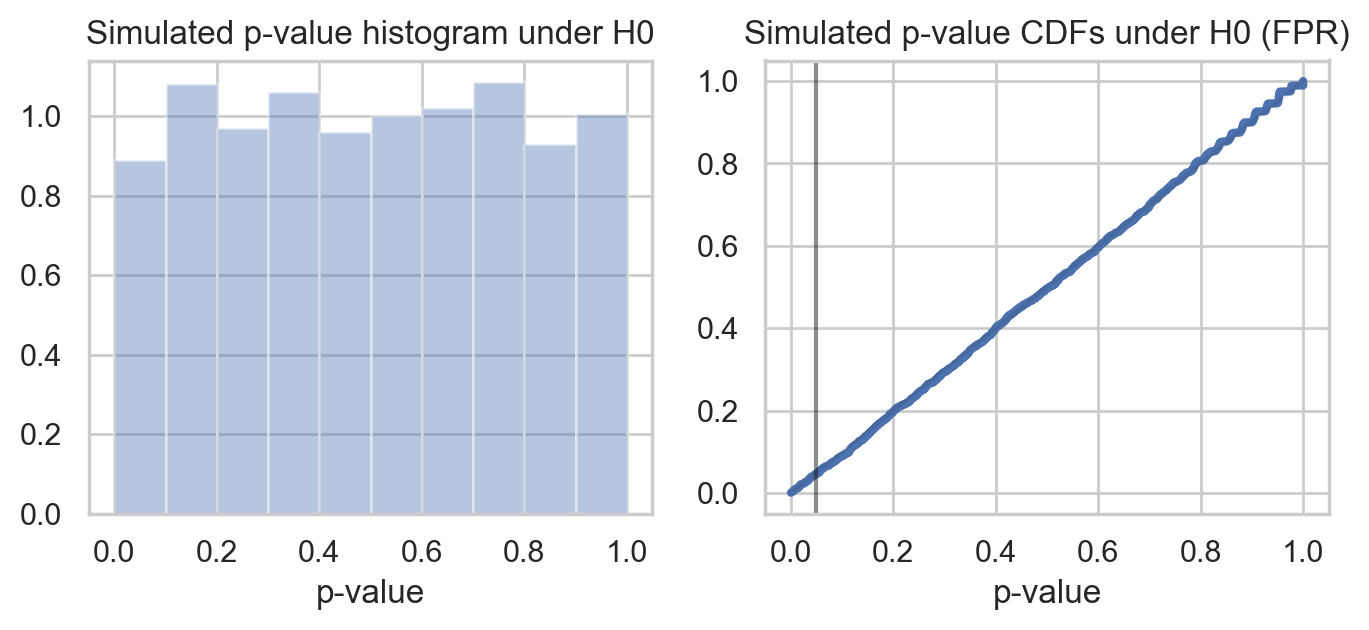

In [211]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), dpi=200)

plot_cdf(aa_data, 'T-test', ax2)

ax2.plot(np.linspace(0, 1, 10000), np.linspace(0, 1, 10000), 'k', alpha=0.1)
ax2.axvline(0.05, color='k', alpha=0.5)
ax2.set_title('Simulated p-value CDFs under H0 (FPR)')
ax2.set_xlabel('p-value')

ax1.set_title('Simulated p-value histogram under H0')
ax1.set_xlabel('p-value')
sns.distplot(aa_data.flatten(), ax=ax1, bins=10, kde=False, norm_hist=True)

#### Различные значения параметров

In [212]:
skew_params = []
for s in np.linspace(0.1, 4, 20):
    skew_params.append({'success_rate': success_rate, 'uplift': uplift, 'beta': beta, 'skew': s, 'N': N, 'NN': NN})

In [213]:
print(np.linspace(0.1, 4, 20))

[0.1        0.30526316 0.51052632 0.71578947 0.92105263 1.12631579
 1.33157895 1.53684211 1.74210526 1.94736842 2.15263158 2.35789474
 2.56315789 2.76842105 2.97368421 3.17894737 3.38421053 3.58947368
 3.79473684 4.        ]


[Logarithmic scale](https://en.wikipedia.org/wiki/Logarithmic_scale)

In [214]:
beta_params = []
for b in np.logspace(0, 3, 20)[::-1]:
    beta_params.append({'success_rate': success_rate, 'uplift': uplift, 'beta': b, 'skew': skew, 'N': N, 'NN': NN})

In [215]:
print(np.logspace(0, 3, 20)[::-1])

[1000.          695.19279618  483.29302386  335.98182863  233.57214691
  162.37767392  112.88378917   78.47599704   54.55594781   37.92690191
   26.36650899   18.32980711   12.74274986    8.8586679     6.15848211
    4.2813324     2.97635144    2.06913808    1.43844989    1.        ]


In [216]:
sr_params = []
for sr in np.logspace(-3, -0.3, 20):
    sr_params.append({'success_rate': sr, 'uplift': uplift, 'beta': beta, 'skew': skew, 'N': N, 'NN': NN})

In [217]:
print(np.logspace(-3, -0.3, 20))

[0.001      0.00138709 0.00192402 0.0026688  0.00370187 0.00513483
 0.00712249 0.00987954 0.01370383 0.01900848 0.02636651 0.03657277
 0.0507298  0.0703669  0.09760536 0.13538762 0.18779508 0.26048905
 0.36132228 0.50118723]


**Всего различных сочетаний параметров**

In [218]:
param_list = skew_params + beta_params + sr_params
len(param_list)

60

**T-test при различных параметрах**

In [219]:
sns.set_style("whitegrid")
frames = [frame_from_params('../data', p, codenames=['ttest_successes_count']) for p in skew_params]
save_gif_and_show('../gifs/powers_ttest.gif', frames)

**Higher skewness drops the power of the t-test significantly.**  
Furthermore, for very skewed distributions, t-test p-values clearly don’t follow uniform distribution under H0.

**In the region of small values, p-values overestimate FPR (the plot lies beyond diagonal in this region).**   
It becomes a “conservative” estimate of FPR. It is fine to use this test, as we can still be sure that FPR <= p-value, but the power of the test is low.

### [Mann-Whitney on number of successes](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test)

- Additional assumptions: no assumptions (a single value of metric must not account for the majority of measurements)
- Problems: complicated hypothesis, computational complexity

In [16]:
frames = [frame_from_params('../data', p, codenames=['ttest_successes_count', 'mannwhitney_successes_count']) for p in skew_params]
save_gif_and_show('../gifs/ttest_mw_powers.gif', frames)

- But when the distribution becomes heavily skewed and the power of the t-test drops, the power of the MW test drops much slower.

- Moreover, MW test p-values under H0 follow uniform distribution even for very skewed views, which means that p-value always gives the correct FPR.

### Bootstrap

In [228]:
np.mean(clicks_control)

0.0934

In [229]:
np.mean(clicks_treatment)

0.1198

In [233]:
%load_ext autoreload
%autoreload 2
from stattests.tests import bootstrap_stat_test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [252]:
bootstrap_stat_test(clicks_0_ab[i,:], clicks_1_ab[i,:])

0.0055

In [253]:
bootstrap_stat_test(clicks_0_aa[i,:], clicks_1_aa[i,:])

0.1685

In [256]:
from tqdm import tqdm

In [ ]:
result_ab = []
for i in tqdm(range(20)):
    result_ab.append(bootstrap_stat_test(clicks_0_ab[i,:], clicks_1_ab[i,:]))

In [265]:
%%time
from joblib import Parallel, delayed
def process(i):
    return bootstrap_stat_test(clicks_0_ab[i,:], clicks_1_ab[i,:])
    
results = Parallel(n_jobs=12)(delayed(process)(i) for i in range(100))

Wall time: 46.8 s


In [271]:
pd.Series(results).describe()

count    100.000000
mean       0.049122
std        0.120696
min        0.000000
25%        0.000475
50%        0.010100
75%        0.035850
max        0.905400
dtype: float64